In [104]:
from IPython.display import display

from ipywidgets import Button, Image, interact, interact_manual, TwoByTwoLayout, FloatText, Label, HBox

import cv2 as cv
import PIL.Image
import io
import numpy as np
import json
import os

INTERVAL = 10
VID_PATH = r"C:\Users\Mykhailo_Tkachuk\Downloads\v1_standing.mp4"
OUTPUT_PATH = r"C:\Users\Mykhailo_Tkachuk\Downloads"

In [105]:
def slide(cap, forward=True, n=INTERVAL):
    if forward:
        if slide.frame_cursor + n < cap.get(cv.CAP_PROP_FRAME_COUNT):
            slide.frame_cursor += n
    else:
        if slide.frame_cursor > 0:
            slide.frame_cursor -= n
    if slide.frame_cursor > cap.get(cv.CAP_PROP_POS_FRAMES):
        while slide.frame_cursor != cap.get(cv.CAP_PROP_POS_FRAMES):
            _ = cap.read()
    if slide.frame_cursor == cap.get(cv.CAP_PROP_POS_FRAMES):
        ret, frame = cap.read()
        if not ret:
            frame = None
        slide.frames_cache.append(frame)
    else:
        frame = slide.frames_cache[slide.frame_cursor//n]  
        
    return cv.cvtColor(frame, cv.COLOR_BGR2RGB)
slide.frame_cursor = 0
slide.frames_cache = []

In [106]:
def compress_to_bytes(data, fmt='png'):
    """
    Helper function to compress image data via PIL/Pillow.
    """
    buff = io.BytesIO()
    img = PIL.Image.fromarray(data)    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

In [107]:
cap = cv.VideoCapture(VID_PATH)
slide.frame_cursor = -INTERVAL
slide.frames_cache = []

canvas = Image(value=compress_to_bytes(slide(cap)))

def render(b, cap, canvas_=canvas, forward=True, n=INTERVAL):
    canvas_.value = compress_to_bytes(slide(cap, forward=forward, n=n))
    current.value = f'cursor at: {slide.frame_cursor}'
    
try:
    with open(os.path.join(OUTPUT_PATH, 'checkpoint.json')) as f:
        annotations = json.load(f)
except:
    annotations = {}
    
def annotate(b):
    annotations[str(slide.frame_cursor)] = val.value
    with open(os.path.join(OUTPUT_PATH, 'checkpoint.json'), 'w') as f:
        json.dump(annotations, f)

r = Button(description='Forward')
r.on_click(lambda x: render(x, cap))
l = Button(description='Back')
l.on_click(lambda x: render(x, cap, forward=False))
val = FloatText(val=0)
confirm = Button(description='Set')
confirm.on_click(annotate)
current = Label(value=f'cursor at: {slide.frame_cursor}')
layout = TwoByTwoLayout(top_left=l,
                        top_right=r,
               bottom_left=HBox([val, confirm]),
               bottom_right=current)

display(canvas)
display(layout)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x07\x80\x00\x00\x048\x08\x02\x00\x00\x00g\xb1V\x14\x…

TwoByTwoLayout(children=(Button(description='Back', layout=Layout(grid_area='top-left'), style=ButtonStyle()),…

In [117]:
with open(os.path.join(OUTPUT_PATH, 'checkpoint.json')) as f:
    annotations = json.load(f)
keys = sorted(list(annotations.keys()), key=lambda x: int(x))

with open(os.path.join(OUTPUT_PATH,'default.txt'),'w') as f:
    for i in range(1,len(keys)):
        dst_interpolation = np.linspace(annotations[keys[i-1]], annotations[keys[i]], int(keys[i]) - int(keys[i-1])+1)
        for frame, dst in zip(range(int(keys[i-1]),int(keys[i])),dst_interpolation):
            f.write(f'{frame} {dst:.1f} 1\n')

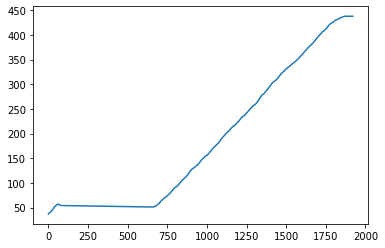

In [118]:
import matplotlib.pyplot as plt
plt.plot([int(k) for k in keys], [annotations[k] for k in keys])